In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.datasets import load_UCR_UEA_dataset
from sktime.classification.hybrid import HIVECOTEV2

from sklearn.metrics import classification_report, precision_recall_fscore_support 

import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train, y_train = load_UCR_UEA_dataset(name="Strawberry",
                                        split='train', 
                                        return_type='numpy3D',
                                        extract_path="./data")
X_test, y_test = load_UCR_UEA_dataset(name="Strawberry",
                                      split='test', 
                                      return_type='numpy3D',
                                      extract_path='./data')

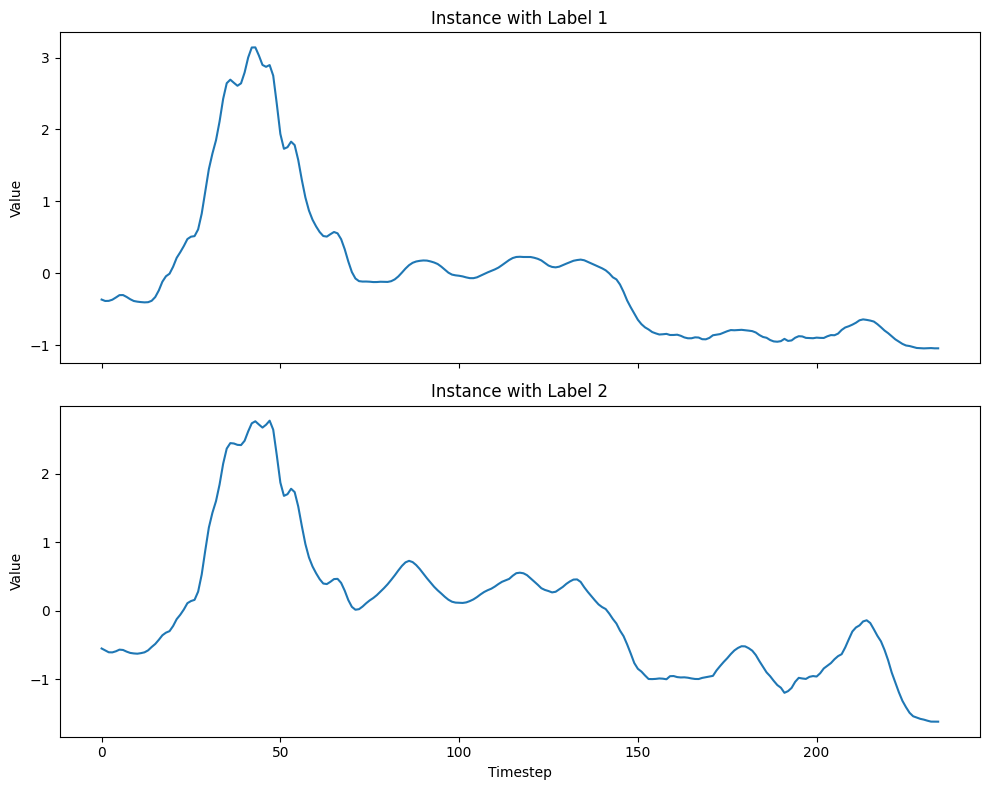

In [3]:
def find_instance_with_label(X, y, label):
    indices = np.where(y == label)[0]
    if len(indices) == 0:
        raise ValueError(f"No instance found with label {label}")
    instance = X[indices[0]]
    
    return instance

instance_label_1 = find_instance_with_label(X_train, y_train, '1')
instance_label_2 = find_instance_with_label(X_train, y_train, '2')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

lines1 = ax1.plot(instance_label_1.T)
ax1.set_ylabel("Value")
ax1.set_title("Instance with Label 1")

lines2 = ax2.plot(instance_label_2.T)
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Value")
ax2.set_title("Instance with Label 2")

plt.tight_layout()
plt.show()

## HIVE-COTE

In [4]:
indices_1 = np.where(y_train == '1')[0]
indices_2 = np.where(y_train == '2')[0]

selected_indices_1 = np.random.choice(indices_1, size=50, replace=False)
selected_indices_2 = np.random.choice(indices_2, size=50, replace=False)

selected_indices = np.concatenate([selected_indices_1, selected_indices_2])

X_train_selected = X_train[selected_indices]
y_train_selected = y_train[selected_indices]

In [6]:
%%time

stc_params = {
    "n_shapelet_samples":50,
    "max_shapelets":50,
    "time_limit_in_minutes":5,
    "contract_max_n_shapelet_samples":50,
}

drcif_params = {
    "n_estimators":5,
    "n_intervals":2,        
    "att_subsample_size":8,
    "min_interval":3,
    "max_interval":None,
    "base_estimator":"CIT",
}

arsenal_params = {
    "num_kernels":1000,
    "n_estimators":25, 
}

tde_params = None

clf = HIVECOTEV2(
    stc_params=stc_params,
    drcif_params=drcif_params,
    arsenal_params=arsenal_params,
    tde_params=tde_params,
    time_limit_in_minutes=10,
    n_jobs=-1,
    random_state=42
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

clf_report = classification_report(y_test, y_pred)

print(clf_report)

              precision    recall  f1-score   support

           1       0.94      0.98      0.96       132
           2       0.99      0.97      0.98       238

    accuracy                           0.97       370
   macro avg       0.97      0.98      0.97       370
weighted avg       0.97      0.97      0.97       370

CPU times: total: 11min 1s
Wall time: 12min 43s


### Can other models achieve the same performance faster?

In [10]:
from sktime.classification.dictionary_based import WEASEL, MUSE

In [11]:
%%time

weasel = WEASEL(alphabet_size=3, random_state=42)
weasel.fit(X_train, y_train)
y_pred = weasel.predict(X_test)

clf_report = classification_report(y_test, y_pred)

print(clf_report)

              precision    recall  f1-score   support

           1       0.93      0.98      0.96       132
           2       0.99      0.96      0.97       238

    accuracy                           0.97       370
   macro avg       0.96      0.97      0.97       370
weighted avg       0.97      0.97      0.97       370

CPU times: total: 5.2 s
Wall time: 4.93 s


In [12]:
%%time

muse = MUSE(n_jobs=-1, random_state=42)
muse.fit(X_train, y_train)
y_pred = muse.predict(X_test)

clf_report = classification_report(y_test, y_pred)

print(clf_report)

              precision    recall  f1-score   support

           1       0.95      0.98      0.96       132
           2       0.99      0.97      0.98       238

    accuracy                           0.97       370
   macro avg       0.97      0.97      0.97       370
weighted avg       0.97      0.97      0.97       370

CPU times: total: 24.6 s
Wall time: 16.7 s
